In [1]:
#importing necessary libraries, etc.
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
import math 
from random import uniform
import matplotlib.patches as mpatches
from sklearn.cluster import KMeans

In [2]:
#reading in the eruptions csv file
eruptions = pd.read_csv('Eruptions.csv')

In [3]:
#split the eruptions data into arrays for its two features x1 (eruptions) and x2 (waiting)
x1 = np.asarray(eruptions['eruptions'])
x2 = np.asarray(eruptions['waiting'])

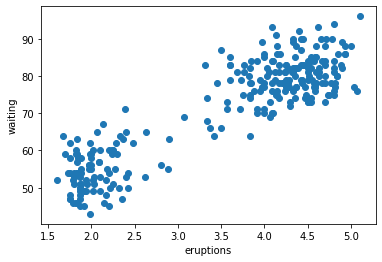

In [4]:
#plotting our eruptions and waiting features against each other so that each point has an eruption
#and waiting value
plt.scatter(x1, x2)
plt.xlabel('eruptions')
plt.ylabel('waiting')
plt.show()

In [5]:
#function for calculating one individual value for an array N, the probability density
#sources and approach for the formulas are mentioned in the writeup
def calculate_N(x1, x2, mu1, mu2, var1, var2):
    exp1 = -1*((x1 - mu1)**2)/(2*(var1))
    exp2 = -1*((x2 - mu2)**2)/(2*(var2))
    pre_exp1 = 1/(math.sqrt(2*math.pi*var1))
    pre_exp2 = 1/(math.sqrt(2*math.pi*var2))
    feature1 = pre_exp1 * math.exp(exp1)  
    feature2 = pre_exp2 * math.exp(exp2)
    return feature1*feature2

In [6]:
#a function for filling the array N, the probability density, by using calculate_N to calculate each individual
#value for the N array and appending it to the N array
def fill_N(x1, x2, mu, var):
    N = []
    for i in range(len(x1)):
        N.append(calculate_N(x1[i], x2[i], mu[0], mu[1], var[0], var[1]))
    return np.asarray(N)

In [7]:
#function for calculating the responsibilities array for each cluster 
#sources and approach for the formulas are mentioned in the writeup
def calculate_responsibilities(pi1, N1, pi2, N2):
    num1 = np.dot(pi1, N1)
    num2 = np.dot(pi2, N2)
    denom = num1 + num2
    r1 = num1 / denom
    r2 = num2 / denom
    return np.asarray(r1), np.asarray(r2)

In [8]:
#function for the E phase. Taking in our data, mean vectors, variance vectors, and pi values,
#the function calls fill_N to calculate N for each cluster and then calls calculate_responsibilities
#to calculate the responsibility array for each cluster
def E_phase(x1, x2, mu_1, mu_2, var_1, var_2, pi1, pi2):
    N1 = fill_N(x1, x2, mu_1, var_1)
    N2 = fill_N(x1, x2, mu_2, var_2)
    r1, r2 = calculate_responsibilities(pi1, N1, pi2, N2)
    return N1, N2, r1, r2

In [9]:
#function for the M phase. Taking in our data and responsibility arrays, we calculate the total responsibility
#for each cluster, the new pi values for each cluster, the new mean vectors for each cluster, and the new
#variance vectors for each cluster
#sources and approach for the formulas are mentioned in the writeup
def M_phase(r1, r2, x1, x2):
    cluster1_resp = sum(r1)
    cluster2_resp  = sum(r2)
    pi1_new = cluster1_resp / (cluster1_resp + cluster2_resp)
    pi2_new = cluster2_resp / (cluster1_resp + cluster2_resp)
    mu1_new = [sum(np.multiply(r1,x1))/cluster1_resp, sum(np.multiply(r1,x2))/cluster1_resp]
    mu2_new = [sum(np.multiply(r2,x1))/cluster2_resp, sum(np.multiply(r2,x2))/cluster2_resp]
    
    num1 = np.multiply(r1, np.multiply(np.subtract(x1,mu1_new[0]), np.subtract(x1,mu1_new[0])))
    num2 = np.multiply(r1, np.multiply(np.subtract(x2,mu1_new[1]), np.subtract(x2,mu1_new[1])))
    num3 = np.multiply(r2, np.multiply(np.subtract(x1,mu2_new[0]), np.subtract(x1,mu2_new[0])))
    num4 = np.multiply(r2, np.multiply(np.subtract(x2,mu2_new[1]), np.subtract(x2,mu2_new[1])))

    var1_new = [sum(num1)/sum(r1), sum(num2)/sum(r1)]
    var2_new = [sum(num3)/sum(r2), sum(num4)/sum(r2)]
    
    return pi1_new, pi2_new, mu1_new, mu2_new, var1_new, var2_new

In [10]:
#function to calculate log loss for a particular iteration
#sources and approach for the formulas are mentioned in the writeup
def calculate_log_likelihood(pi1_new, pi2_new, N1, N2):
    log = 0
    for i in range(len(N1)):
        c1 = pi1_new * N1[i]
        c2 = pi2_new * N2[i]
        c_sum = c1 + c2
        log += math.log10(c_sum) 
    return log

In [11]:
#a function for running the EM algorithm, which alternates between the E and M phases. It continues to run
#until we reach the break condition. For each iteration it runs the E phase to calculate responsibilities
#and then those responsibilities are used in the M phase to calculate the new pi's, means, and variances.
#For each iteration, the log likelihood from the previous iteration is subtracted from the log loss of the current
#iteration. When this difference falls below 0.000000001, we break out of the EM algorithm, because this means
#the log likelihood has stabalized. The function returns the count of iterations it took to converge, the final
#mean, variance, and pi values, and two arrays containing the mean vectors for each cluster after each iteraion
def run_algorithm(x1, x2, mu_1, mu_2, var_1, var_2, pi1, pi2):
    prev = 0
    new = 0
    count = 0
    averages_1 = [mu_1]
    averages_2 = [mu_2]
    while (True):
        N1, N2, r1, r2 = E_phase(x1, x2, mu_1, mu_2, var_1, var_2, pi1, pi2)
        pi1, pi2, mu_1, mu_2, var_1, var_2 = M_phase(r1, r2, x1, x2)
        prev = new
        new = calculate_log_likelihood(pi1, pi2, N1, N2)
        diff = abs(new - prev)
                
        averages_1.append(mu_1)
        averages_2.append(mu_2)
        count += 1
        
        if diff < 0.000000001: break

    return count, mu_1, mu_2, var_1, var_2, pi1, pi2, averages_1, averages_2

In [12]:
#we initialize initial guesses for the pi values and mean and variance vectors. We then run the EM algorithm 
#by feeding in the initial guess and allowing it to run until convergence. We then print some of the import
#results/outputs to better understand the final distributions
mu_1 = [0.0, 30]
mu_2 = [2.0, 10]
var_1 = [1.0, 10]
var_2 = [0.5, 60]
pi1 = 0.7
pi2 = 0.3

count, mu_1, mu_2, var_1, var_2, pi1, pi2, averages_1, averages_2 = run_algorithm(x1, x2, mu_1, mu_2, 
                                                                                  var_1, var_2, pi1, pi2)
print("count: ", count)
print("mu1: ", mu_1)
print("mu2: ", mu_2)
print("var1: ", var_1)
print("var2: ", var_2)
print("pi1: ", pi1)
print("pi2: ", pi2)

count:  15
mu1:  [2.0379156709736153, 54.4929537355502]
mu2:  [4.291070489652127, 79.98562153747666]
var1:  [0.07033674972634543, 33.755846248666884]
var2:  [0.16815112070182417, 35.77335135619722]
pi1:  0.3565167358929937
pi2:  0.6434832641070062


In [13]:
#we take our mean/average arrays, each of which represents the mean vector values for each iteration for
#each respective cluster. We isolate each mean vector for all the iterations (one for cluster 1 eruption means,
#one for cluster 1 waiting means, one for cluster 2 eruption means, and one for cluster 2 waiting means). We also
#create an array of integers representing the iterations (ranging from 0 to count of iterations)
cluster_1_eruption_mean = np.asarray(averages_1).transpose()[0]
cluster_1_waiting_mean = np.asarray(averages_1).transpose()[1]
cluster_2_eruption_mean = np.asarray(averages_2).transpose()[0]
cluster_2_waiting_mean = np.asarray(averages_2).transpose()[1]
iterations_array = np.arange(count+1)

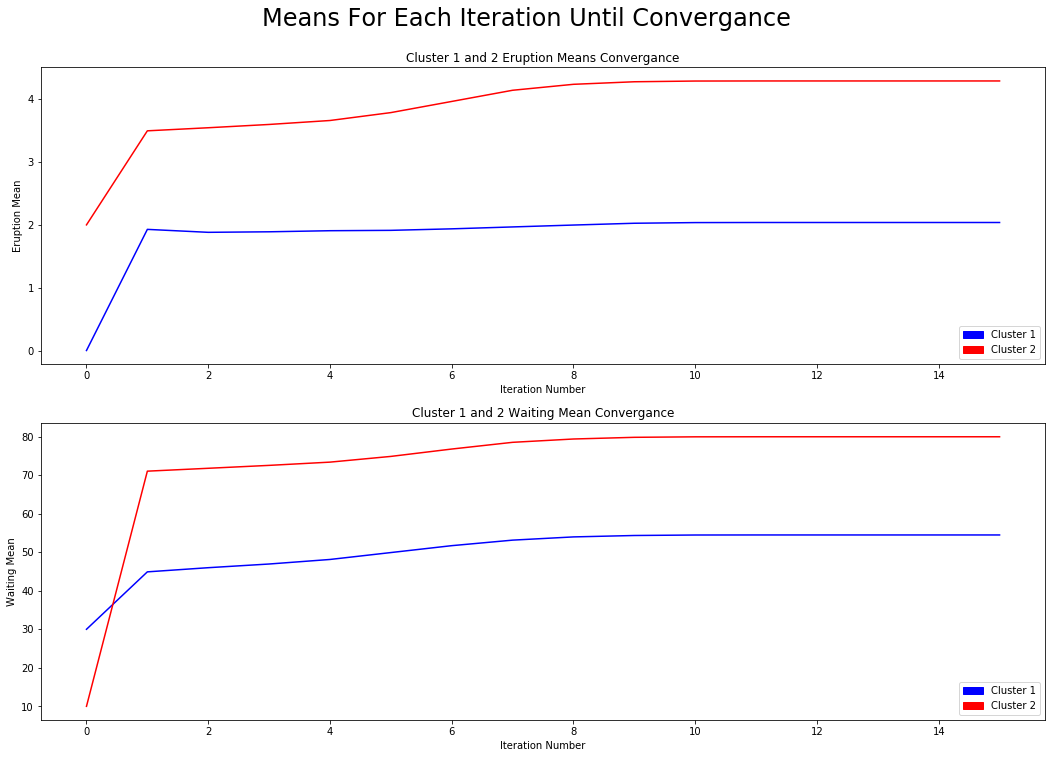

In [14]:
#taking the arrays from the step above and plotting how the means change with each iteration until they
#converge. We plot eruption means against iterations for clusters 1 and 2 on one plot and waiting means 
#against iterations for clusters 1 and 2 on the other plot
fig = plt.figure(figsize=(18,12))
fig.suptitle('Means For Each Iteration Until Convergance', fontsize=24, y = 0.95)

plt.subplot(2, 1, 1)
plt.plot(iterations_array, cluster_1_eruption_mean, 'b', iterations_array, cluster_2_eruption_mean, 'r')
plt.title("Cluster 1 and 2 Eruption Means Convergance")
plt.xlabel('Iteration Number')
plt.ylabel('Eruption Mean')
blue_patch = mpatches.Patch(color='blue', label='Cluster 1')
red_patch = mpatches.Patch(color='red', label='Cluster 2')
plt.legend(handles=[blue_patch, red_patch], loc='lower right')

plt.subplot(2, 1, 2)
plt.plot(iterations_array, cluster_1_waiting_mean, 'b', iterations_array, cluster_2_waiting_mean, 'r')
plt.title("Cluster 1 and 2 Waiting Mean Convergance")
plt.xlabel('Iteration Number')
plt.ylabel('Waiting Mean')
blue_patch = mpatches.Patch(color='blue', label='Cluster 1')
red_patch = mpatches.Patch(color='red', label='Cluster 2')
plt.legend(handles=[blue_patch, red_patch], loc='lower right')


plt.show()

In [15]:
#now, we run our EM algorithm 50 times. Each time through the algorithm, we start with a random initial guess for
#our mean and variance vectors and our pi values (within pre-defined ranges). We use our run_algorithm function
#to return the number of iterations for each time through the algorithm that it takes to converge. In the end,
#we return one array with just the counts for each of the 50 iterations and another array with the counts, 
#variances, means, and pi's for each of the 50 iterations
counts_and_vals = []
just_counts = []
for i in range(50):  
    mu_1_copy = [uniform(0.0, 6.0) , uniform(0.0, 120.0)]
    mu_2_copy = [uniform(0.0, 6.0) , uniform(0.0, 120.0)]
    var_1_copy = [uniform(0.0, 6.0) , uniform(30.0, 250.0)]
    var_2_copy = [uniform(0.0, 6.0) , uniform(30.0, 250.0)]
    pi1_copy = uniform(0.001, 1.0)
    pi2_copy = 1.0 - pi1_copy
     
    count = run_algorithm(x1, x2, mu_1_copy, mu_2_copy, var_1_copy, var_2_copy, pi1_copy, pi2_copy)[0]
    
    counts_and_vals.append([count, mu_1_copy, mu_2_copy, var_1_copy, var_2_copy, pi1_copy, pi2_copy])
    just_counts.append(count)

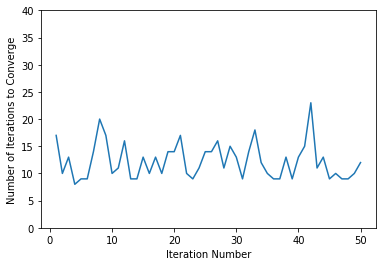

In [16]:
#here we plot a distribution of the number of iterations it took to converge for 50 seperate runs of our EM 
#algorithm with 50 random initial guesses
x = np.arange(1,51)
y = just_counts
plt.plot(x,y)
plt.xlabel('Iteration Number')
plt.ylabel('Number of Iterations to Converge')
plt.ylim((0, 40))
plt.show()

In [17]:
#this represents the average number of iterations it takes to converge for our 50 random initial guesses
print("Average Iterations to Converge: ", np.mean(just_counts))

Average Iterations to Converge:  12.26


In [18]:
#we run k-means on our full dataset and isolate the indices associated with each label. In this case, 
#we chose to make our first cluster the points that the algorithm labeled as 1 and the second cluster 
#as the points that the algorithm labeled as 0, which is why the name and values might seem flipped. However, we did 
#this intentionally to treat the clusters in the order we wanted them in
total_data = np.asarray(eruptions)

kmeans = KMeans(n_clusters=2, random_state=0).fit(total_data)

indices_where_zero = np.where(kmeans.labels_ == 1)
indices_where_one = np.where(kmeans.labels_ == 0)

In [19]:
#seperating our data into seperate numpy arrays based on whether they are labeled 1 or 0 (again, those labeled
#1 are in the first cluster and those labeled 0 are in the second cluster -- this was the convention we chose)
cluster_1 = []
cluster_2 = []

for i in range(len(indices_where_zero)):
    cluster_1.append(total_data[indices_where_zero[i]])

for i in range(len(indices_where_one)):
    cluster_2.append(total_data[indices_where_one[i]])

cluster_1 = np.asarray(cluster_1)[0]
cluster_2 = np.asarray(cluster_2)[0]

In [20]:
#in this section, we calculate our pi, variance, and mean guesses for our EM algorithm using the clusters we have
#from k-means. The pi values are simply the normalized proportion of points in each cluster. In our report, we 
#explain our max likelihood process/calculation, so please reference it, but for now, what is important is that 
#we calculated the mean of each feature for each cluster and the variance of each feature for each cluster 
pi1_guess = len(cluster_1)/(len(cluster_1)+ len(cluster_2))
pi2_guess = len(cluster_2)/(len(cluster_1)+ len(cluster_2))

cluster_1_eruption = cluster_1.transpose()[0]
cluster_1_waiting = cluster_1.transpose()[1]
cluster_2_eruption = cluster_2.transpose()[0]
cluster_2_waiting = cluster_2.transpose()[1]

cluster_1_eruption_mean = np.mean(cluster_1_eruption)
cluster_1_waiting_mean = np.mean(cluster_1_waiting)
cluster_2_eruption_mean = np.mean(cluster_2_eruption)
cluster_2_waiting_mean = np.mean(cluster_2_waiting)

cluster_1_eruption_var = np.var(cluster_1_eruption)
cluster_1_waiting_var = np.var(cluster_1_waiting)
cluster_2_eruption_var = np.var(cluster_2_eruption)
cluster_2_waiting_var = np.var(cluster_2_waiting)

In [21]:
#we combine our calculated means and variances into their proper vectors and populate our algorithm/function
#with the guess values. We then print our results (count of iterations, means, variances, pi's)
mu_1 = [cluster_1_eruption_mean, cluster_1_waiting_mean]
mu_2 = [cluster_2_eruption_mean, cluster_2_waiting_mean]
var_1 = [cluster_1_eruption_var, cluster_1_waiting_var]
var_2 = [cluster_2_eruption_var, cluster_2_waiting_var]
pi1 = pi1_guess
pi2 = pi2_guess

count, mu_1, mu_2, var_1, var_2, pi1, pi2, averages_1, averages_2 = run_algorithm(x1, x2, mu_1, mu_2, 
                                                                                  var_1, var_2, pi1, pi2)
print("count: ", count)
print("mu1: ", mu_1)
print("mu2: ", mu_2)
print("var1: ", var_1)
print("var2: ", var_2)
print("pi1: ", pi1)
print("pi2: ", pi2)

count:  7
mu1:  [2.0379156722446683, 54.4929537498756]
mu2:  [4.291070490727872, 79.98562154967868]
var1:  [0.0703367507776422, 33.75584635476229]
var2:  [0.16815111935952, 35.77335119028006]
pi1:  0.356516736401337
pi2:  0.6434832635986629


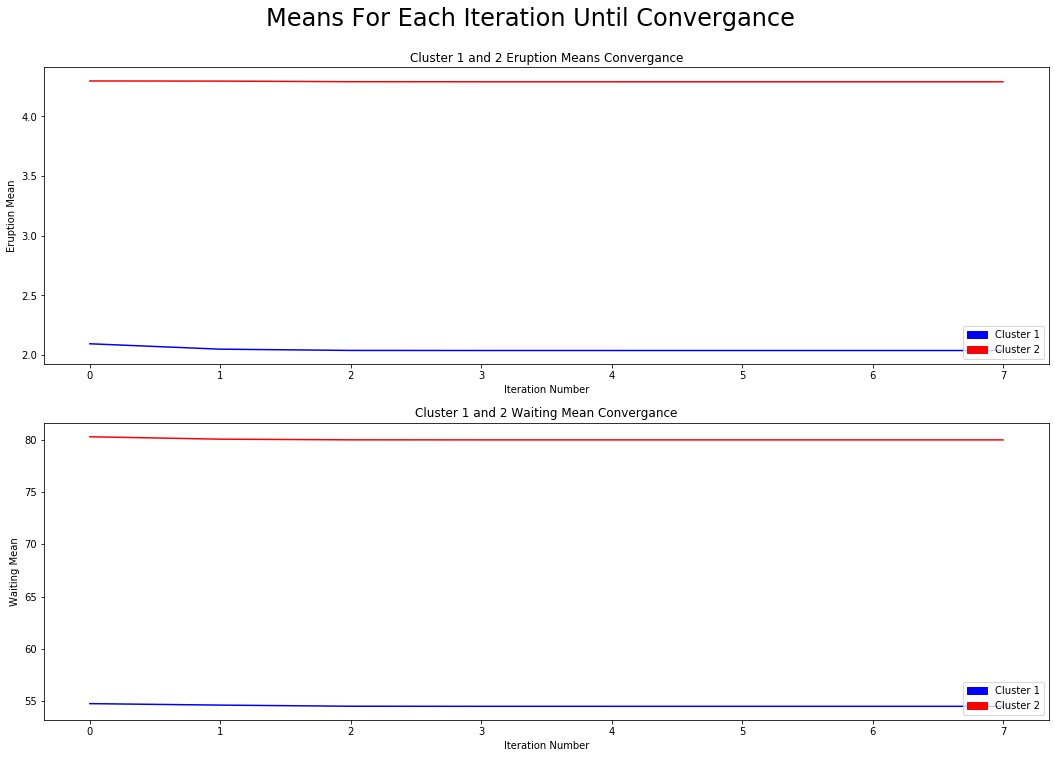

In [22]:
#we take our mean/average arrays, each of which represents the mean vector values for each iteration for
#each respective cluster. We isolate each mean vector for all the iterations (one for cluster 1 eruption means,
#one for cluster 1 waiting means, one for cluster 2 eruption means, and one for cluster 2 waiting means). We also
#create an array of integers representing the iterations (ranging from 0 to count of iterations)
#We then take the arrays and plot how the means change with each iteration until they converge. We plot 
#eruption means against iterations for clusters 1 and 2 on one plot and waiting means against iterations 
#for clusters 1 and 2 on the other plot
cluster_1_eruption_mean = np.asarray(averages_1).transpose()[0]
cluster_1_waiting_mean = np.asarray(averages_1).transpose()[1]
cluster_2_eruption_mean = np.asarray(averages_2).transpose()[0]
cluster_2_waiting_mean = np.asarray(averages_2).transpose()[1]
iterations_array = np.arange(count+1)

fig = plt.figure(figsize=(18,12))
fig.suptitle('Means For Each Iteration Until Convergance', fontsize=24, y = 0.95)

plt.subplot(2, 1, 1)
plt.plot(iterations_array, cluster_1_eruption_mean, 'b', iterations_array, cluster_2_eruption_mean, 'r')
plt.title("Cluster 1 and 2 Eruption Means Convergance")
plt.xlabel('Iteration Number')
plt.ylabel('Eruption Mean')
blue_patch = mpatches.Patch(color='blue', label='Cluster 1')
red_patch = mpatches.Patch(color='red', label='Cluster 2')
plt.legend(handles=[blue_patch, red_patch], loc='lower right')

plt.subplot(2, 1, 2)
plt.plot(iterations_array, cluster_1_waiting_mean, 'b', iterations_array, cluster_2_waiting_mean, 'r')
plt.title("Cluster 1 and 2 Waiting Mean Convergance")
plt.xlabel('Iteration Number')
plt.ylabel('Waiting Mean')
blue_patch = mpatches.Patch(color='blue', label='Cluster 1')
red_patch = mpatches.Patch(color='red', label='Cluster 2')
plt.legend(handles=[blue_patch, red_patch], loc='lower right')


plt.show()